# Regression Layer

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.utils import resample
import warnings
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from scipy.stats import friedmanchisquare, rankdata
import shap
import scikit_posthocs as sp
from sklearn.feature_selection import SelectFromModel
from IPython.display import FileLink, display
import math
from sklearn.ensemble import RandomForestClassifier
from skopt.space import Integer, Real
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree
from skopt.space import Real, Integer, Categorical
from skopt.callbacks import VerboseCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import LocalOutlierFactor
from lightgbm import LGBMRegressor
from IPython.display import display, FileLink

/home/researchsrv1/anaconda3/envs/des4clem/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preparation before training

In [2]:
# Call Dataset
pd.set_option('display.max_rows', 10)
initial_df = pd.read_csv('3labelv4Regression.csv')
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2763 entries, 0 to 2762
Columns: 318 entries, GENDER to total_sum
dtypes: float64(47), int64(2), object(269)
memory usage: 6.7+ MB


In [3]:
# All categorical features except for label
cols = initial_df.columns
num_cols = initial_df._get_numeric_data().columns
categorical_features = list(set(cols) - set(num_cols))
categorical_features.remove('depression_category')

# Label Encode all categorical, but keep missing values
le_initial_df = initial_df.copy()
dropped_labels = le_initial_df['depression_category']
le_initial_df = le_initial_df.drop('depression_category', axis = 1)

for col in le_initial_df.columns:
    if le_initial_df[col].dtype == 'object':
        le_initial_df[col] = le_initial_df[col].fillna('missing')

        label_encoder = LabelEncoder()
        le_initial_df[col] = label_encoder.fit_transform(le_initial_df[col])

        missing_value_index = np.where(label_encoder.classes_ == 'missing')[0]
        
        le_initial_df[col] = le_initial_df[col].replace(missing_value_index, np.nan)

le_initial_df = pd.concat([le_initial_df, dropped_labels], axis = 1)

In [4]:
le_initial_df

,GENDER,AGE,AGEGRP,DEGREE_RECODE,EDUC,RACE_RECODE,HISPANIC,ETHGRP,MILITARY,JAIL,...,IWLOC5,IWLOC6,STRUCTQ,BUILD,OTBUILD,COMBUILD,CASECOMP,CASEDIF,total_sum,depression_category
0,1,62,0,5,3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,2.0,2.0,10.0,1.0,2,normal
1,1,79,2,2,2,2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,2.0,3.0,10.0,2.0,3,normal
2,0,58,0,4,3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,2.0,2.0,10.0,1.0,2,normal
3,0,79,2,5,3,2,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,3.0,3.0,4.0,7.0,1.0,4,normal
4,1,68,1,6,3,2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,2.0,3.0,10.0,1.0,3,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,1,61,0,1,0,2,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,3.0,10.0,2.0,14,moderatesevere
2759,1,70,1,1,0,4,1.0,2.0,0.0,0.0,...,0.0,0.0,1.0,NaN,NaN,NaN,10.0,2.0,11,moderatesevere
2760,1,70,1,3,2,2,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,2.0,2.0,2.0,10.0,3.0,10,moderatesevere
2761,0,63,0,4,3,2,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,11,moderatesevere


In [5]:
# Seperate and Combine
le_df_normal = le_initial_df[le_initial_df['depression_category'] == 'normal']
le_df_mild = le_initial_df[le_initial_df['depression_category'] == 'mild']
le_df_moderatesevere = le_initial_df[le_initial_df['depression_category'] == 'moderatesevere']

le_df_depression = pd.concat([le_df_normal, le_df_mild, le_df_moderatesevere], ignore_index = False)

le_df_depression['depression_category'] = 'depression'

# Check depression category counts
dataframes = [le_df_normal, le_df_mild, le_df_moderatesevere]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['depression_category'].value_counts()
label_counts

normal            1308
mild               940
moderatesevere     515
Name: depression_category, dtype: int64

In [6]:
# Some outlier.
# threshold = int(0.8 * le_df_normal.shape[1])
# le_df_normal = le_df_normal.dropna(thresh = threshold)
# threshold = int(0.8 * le_df_depression.shape[1])
# le_df_depression = le_df_depression.dropna(thresh = threshold)

# Check depression category counts
dataframes = [le_df_normal, le_df_mild, le_df_moderatesevere]
le_initial_df = pd.concat(dataframes, ignore_index=True)
label_counts = le_initial_df['depression_category'].value_counts()

In [7]:
# Imputation
different_le_dfs = [le_df_normal, le_df_mild, le_df_moderatesevere]
imputed_le_dfs = []
from sklearn.impute import IterativeImputer
for le_df in different_le_dfs:
    y = le_df['depression_category']
    X = le_df.drop('depression_category', axis = 1)
    
    imputer = SimpleImputer(strategy='median')
    imputed_data = imputer.fit_transform(X)
    imputed_df = pd.DataFrame(imputed_data, columns = X.columns)

    imputed_df['depression_category'] = y.reset_index(drop = True)
    imputed_le_dfs.append(imputed_df)

concatenated_le_dfs = pd.concat(imputed_le_dfs, ignore_index = True)
concatenated_le_dfs

,GENDER,AGE,AGEGRP,DEGREE_RECODE,EDUC,RACE_RECODE,HISPANIC,ETHGRP,MILITARY,JAIL,...,IWLOC5,IWLOC6,STRUCTQ,BUILD,OTBUILD,COMBUILD,CASECOMP,CASEDIF,total_sum,depression_category
0,1.0,62.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,2.0,2.0,10.0,1.0,2.0,normal
1,1.0,79.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,2.0,3.0,10.0,2.0,3.0,normal
2,0.0,58.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,2.0,2.0,10.0,1.0,2.0,normal
3,0.0,79.0,2.0,5.0,3.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,3.0,3.0,4.0,7.0,1.0,4.0,normal
4,1.0,68.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.0,2.0,3.0,10.0,1.0,3.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,1.0,61.0,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,3.0,10.0,2.0,14.0,moderatesevere
2759,1.0,70.0,1.0,1.0,0.0,4.0,1.0,2.0,0.0,0.0,...,0.0,0.0,1.0,2.0,2.0,2.0,10.0,2.0,11.0,moderatesevere
2760,1.0,70.0,1.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,2.0,2.0,2.0,10.0,3.0,10.0,moderatesevere
2761,0.0,63.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,11.0,moderatesevere


In [8]:
# Full label encode depression category
fully_LE_concatenated_le_dfs = concatenated_le_dfs.copy()
fully_LE_concatenated_le_dfs['depression_category'] = label_encoder.fit_transform(fully_LE_concatenated_le_dfs['depression_category'])

# The dataset after category connect, imputation, and label encoding
splitted_dataset = fully_LE_concatenated_le_dfs.copy()
splitted_dataset = splitted_dataset.drop('depression_category', axis = 1)
splitted_dataset

,GENDER,AGE,AGEGRP,DEGREE_RECODE,EDUC,RACE_RECODE,HISPANIC,ETHGRP,MILITARY,JAIL,...,IWLOC4,IWLOC5,IWLOC6,STRUCTQ,BUILD,OTBUILD,COMBUILD,CASECOMP,CASEDIF,total_sum
0,1.0,62.0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,2.0,10.0,1.0,2.0
1,1.0,79.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,2.0,3.0
2,0.0,58.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,2.0,2.0,10.0,1.0,2.0
3,0.0,79.0,2.0,5.0,3.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,3.0,3.0,4.0,7.0,1.0,4.0
4,1.0,68.0,1.0,6.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,3.0,2.0,3.0,10.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2758,1.0,61.0,0.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,3.0,10.0,2.0,14.0
2759,1.0,70.0,1.0,1.0,0.0,4.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,2.0,2.0,2.0,10.0,2.0,11.0
2760,1.0,70.0,1.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,1.0,2.0,2.0,2.0,10.0,3.0,10.0
2761,0.0,63.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,11.0


In [9]:
warnings.filterwarnings('ignore')

### Regression Training

In [10]:
# Optimized parameters
regressors = {
    'CBR': CatBoostRegressor(verbose=0, iterations=2000, learning_rate=0.01, depth=5),
    'XGBR': XGBRegressor(learning_rate=0.04403027347366962, max_depth=3, n_estimators=238),
    'LGBMR': LGBMRegressor(learning_rate=0.02904035023286438, num_leaves=20, n_estimators=170),
    'GBR': GradientBoostingRegressor(learning_rate=0.03, max_depth=2, n_estimators=700),
    'RFR': RandomForestRegressor(max_depth=12, max_features=1.0, n_estimators=300),
    'ETR': ExtraTreesRegressor(max_depth=12, max_features=1.0, n_estimators=64),
    'ABR': AdaBoostRegressor(learning_rate=0.29915504677867777, n_estimators=92)
}

# Default parameters
# regressors = {
#     'CBR': CatBoostRegressor(verbose=0),
#     'XGBR': XGBRegressor(),
#     'LGBMR': LGBMRegressor(),
#     'GBR': GradientBoostingRegressor(),
#     'RFR': RandomForestRegressor(),
#     'ETR': ExtraTreesRegressor(),
#     'ABR': AdaBoostRegressor()
# }

voting_regressor = VotingRegressor(estimators=[
    ('cbr', regressors['CBR']),
    ('xgbr', regressors['XGBR']),
    ('gbr', regressors['GBR']),
    ('abr', regressors['ABR'])
])

regressors['Voting'] = voting_regressor

metric_sums = {name: {'rmse': 0, 'mae': 0, 'r2': 0} for name in regressors.keys()}
metric_stds = {name: {'rmse': 0, 'mae': 0, 'r2': 0} for name in regressors.keys()}
rmse_scores = {name: [] for name in regressors.keys()}
mae_scores = {name: [] for name in regressors.keys()}
r2_scores = {name: [] for name in regressors.keys()}

for random_state in range(10):
    print(f'Processing for Random State: {random_state}')

    X = splitted_dataset.drop('total_sum', axis=1)
    y = splitted_dataset['total_sum']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    lof = LocalOutlierFactor()
    yhat = lof.fit_predict(X_train)

    mask = yhat != -1
    X_train, y_train = X_train[mask], y_train[mask]

    original_columns = X.columns.tolist()

    print(f"Number of training labels after outlier removal: {len(y_train)}")
    print(f"Number of test labels: {len(y_test)}")

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train, columns=original_columns)
    X_test = pd.DataFrame(X_test, columns=original_columns)

    # Feature selection using XGBRegressor
    xgb = XGBRegressor(random_state=random_state)
    xgb.fit(X_train, y_train)
    selector = SelectFromModel(xgb, prefit=True)

    importance = np.abs(xgb.feature_importances_)
    indices = np.argsort(importance)[::-1]
    important_features = [original_columns[i] for i in indices[:50]]

    for reg_name, reg in regressors.items():
        selected_features = important_features
        
        X_train_fi = pd.DataFrame(X_train, columns=original_columns)[selected_features]
        X_test_fi = pd.DataFrame(X_test, columns=original_columns)[selected_features]

        reg.fit(X_train_fi, y_train)
        y_pred = reg.predict(X_test_fi)

        y_pred = np.round(y_pred)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        metric_sums[reg_name]['rmse'] += rmse
        metric_sums[reg_name]['mae'] += mae
        metric_sums[reg_name]['r2'] += r2
        rmse_scores[reg_name].append(rmse)
        mae_scores[reg_name].append(mae)
        r2_scores[reg_name].append(r2)

Processing for Random State: 0
Number of training labels after outlier removal: 1842
Number of test labels: 829
Processing for Random State: 1
Number of training labels after outlier removal: 1838
Number of test labels: 829
Processing for Random State: 2
Number of training labels after outlier removal: 1859
Number of test labels: 829
Processing for Random State: 3
Number of training labels after outlier removal: 1847
Number of test labels: 829
Processing for Random State: 4
Number of training labels after outlier removal: 1846
Number of test labels: 829
Processing for Random State: 5
Number of training labels after outlier removal: 1833
Number of test labels: 829
Processing for Random State: 6
Number of training labels after outlier removal: 1840
Number of test labels: 829
Processing for Random State: 7
Number of training labels after outlier removal: 1849
Number of test labels: 829
Processing for Random State: 8
Number of training labels after outlier removal: 1849
Number of test labe

In [11]:
# Calculate and print the average metrics and their standard deviations
for reg_name in regressors.keys():
    avg_rmse = metric_sums[reg_name]['rmse'] / 10
    avg_mae = metric_sums[reg_name]['mae'] / 10
    avg_r2 = metric_sums[reg_name]['r2'] / 10
    std_rmse = np.std(rmse_scores[reg_name])
    std_mae = np.std(mae_scores[reg_name])
    std_r2 = np.std(r2_scores[reg_name])
    
    print(f"Regressor: {reg_name}")
    print(f"Average RMSE: {avg_rmse} ± {std_rmse}")
    print(f"Average MAE: {avg_mae} ± {std_mae}")
    print(f"Average R2: {avg_r2} ± {std_r2}")
    print("------")

Regressor: CBR
Average RMSE: 2.33212820158642 ± 0.055097288466959646
Average MAE: 1.8145958986731003 ± 0.056023669163409784
Average R2: 0.7425974040934744 ± 0.008382037411545003
------
Regressor: XGBR
Average RMSE: 2.390647518591595 ± 0.06772970382837729
Average MAE: 1.860193003618818 ± 0.06221011148884051
Average R2: 0.7293457710895285 ± 0.01435860604641583
------
Regressor: LGBMR
Average RMSE: 2.3751746454600484 ± 0.06800748162148057
Average MAE: 1.8521109770808202 ± 0.06807739278882169
Average R2: 0.7328791730997409 ± 0.013508317451016535
------
Regressor: GBR
Average RMSE: 2.376531051190981 ± 0.05802369320874543
Average MAE: 1.8563329312424606 ± 0.054385239419334125
Average R2: 0.7326307111215877 ± 0.010908685476682169
------
Regressor: RFR
Average RMSE: 2.4845736390091337 ± 0.06676197760203786
Average MAE: 1.9213510253317245 ± 0.056212303980699686
Average R2: 0.7078724320067347 ± 0.010168136014613706
------
Regressor: ETR
Average RMSE: 2.573527627227243 ± 0.06011802348157688
Avera

### Shap n FN

In [12]:
# Preparation code to make CD diagram from older version of Orange
def compute_CD(avranks, n, alpha="0.05", test="nemenyi"):
    """
    Returns critical difference for Nemenyi or Bonferroni-Dunn test
    according to given alpha (either alpha="0.05" or alpha="0.1") for average
    ranks and number of tested datasets N. Test can be either "nemenyi" for
    for Nemenyi two tailed test or "bonferroni-dunn" for Bonferroni-Dunn test.

    This function is deprecated and will be removed in Orange 3.34.
    """
    k = len(avranks)
    d = {("nemenyi", "0.05"): [0, 0, 1.959964, 2.343701, 2.569032, 2.727774,
                               2.849705, 2.94832, 3.030879, 3.101730, 3.163684,
                               3.218654, 3.268004, 3.312739, 3.353618, 3.39123,
                               3.426041, 3.458425, 3.488685, 3.517073,
                               3.543799],
         ("nemenyi", "0.1"): [0, 0, 1.644854, 2.052293, 2.291341, 2.459516,
                              2.588521, 2.692732, 2.779884, 2.854606, 2.919889,
                              2.977768, 3.029694, 3.076733, 3.119693, 3.159199,
                              3.195743, 3.229723, 3.261461, 3.291224, 3.319233],
         ("bonferroni-dunn", "0.05"): [0, 0, 1.960, 2.241, 2.394, 2.498, 2.576,
                                       2.638, 2.690, 2.724, 2.773],
         ("bonferroni-dunn", "0.1"): [0, 0, 1.645, 1.960, 2.128, 2.241, 2.326,
                                      2.394, 2.450, 2.498, 2.539]}
    q = d[(test, alpha)]
    cd = q[k] * (k * (k + 1) / (6.0 * n)) ** 0.5
    return cd


def graph_ranks(avranks, names, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    This function is deprecated and will be removed in Orange 3.34.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    tempsort = sorted([(a, i) for i, a in enumerate(sums)], reverse=reverse)
    ssums = nth(tempsort, 0)
    sortidx = nth(tempsort, 1)
    nnames = [names[x] for x in sortidx]

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    if cd and cdmethod is None:
        # get pairs of non significant methods

        def get_lines(sums, hsd):
            # get all pairs
            lsums = len(sums)
            allpairs = [(i, j) for i, j in mxrange([[lsums], [lsums]]) if j > i]
            # remove not significant
            notSig = [(i, j) for i, j in allpairs
                      if abs(sums[i] - sums[j]) <= hsd]
            # keep only longest

            def no_longer(ij_tuple, notSig):
                i, j = ij_tuple
                for i1, j1 in notSig:
                    if (i1 <= i and j1 > j) or (i1 < i and j1 >= j):
                        return False
                return True

            longest = [(i, j) for i, j in notSig if no_longer((i, j), notSig)]

            return longest

        lines = get_lines(ssums, cd)
        linesblank = 0.2 + 0.2 + (len(lines) - 1) * 0.1

        # add scale
        distanceh = 0.25
        cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]


    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, fontsize = 14, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=0.7)

    bigtick = 0.1
    smalltick = 0.05

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=0.7)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom")

    k = len(ssums)

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=0.7)
        text(textspace - 0.2, chei, nnames[i], ha="right", va="center")

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * 0.2
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=0.7)
        text(textspace + scalewidth + 0.2, chei, nnames[i],
             ha="left", va="center")

    if cd and cdmethod is None:
        # upper scale
        if not reverse:
            begin, end = rankpos(lowv), rankpos(lowv + cd)
        else:
            begin, end = rankpos(highv), rankpos(highv - cd)

        line([(begin, distanceh), (end, distanceh)], linewidth=0.7)
        line([(begin, distanceh + bigtick / 2),
              (begin, distanceh - bigtick / 2)],
             linewidth=0.7)
        line([(end, distanceh + bigtick / 2),
              (end, distanceh - bigtick / 2)],
             linewidth=0.7)
        text((begin + end) / 2, distanceh - 0.05, "CD",
             ha="center", va="bottom")

        # no-significance lines
        def draw_lines(lines, side=0.05, height=0.1):
            start = cline + 0.2
            for l, r in lines:
                line([(rankpos(ssums[l]) - side, start),
                      (rankpos(ssums[r]) + side, start)],
                     linewidth=2.5)
                start += height

        draw_lines(lines)

    elif cd:
        begin = rankpos(avranks[cdmethod] - cd)
        end = rankpos(avranks[cdmethod] + cd)
        line([(begin, cline), (end, cline)],
             linewidth=2.5)
        line([(begin, cline + bigtick / 2),
              (begin, cline - bigtick / 2)],
             linewidth=2.5)
        line([(end, cline + bigtick / 2),
              (end, cline - bigtick / 2)],
             linewidth=2.5)

    if filename:
        print_figure(fig, filename, **kwargs)

Friedman Test Statistic: 62.0, p-value: 6.011355572699598e-11
Critical Difference: 6.928203230275509


<Figure size 1600x1000 with 0 Axes>

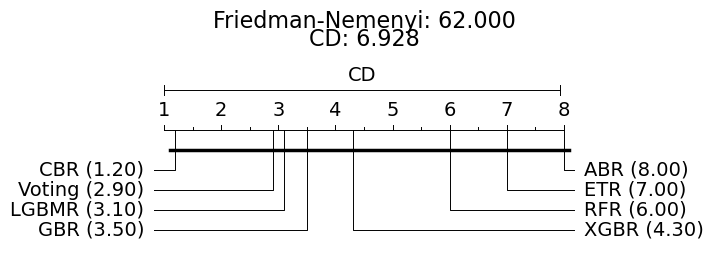

In [13]:
# FN
df = pd.DataFrame(rmse_scores)
df

scores = [df[col].values for col in df.columns]

stat, p = friedmanchisquare(*scores)
print(f'Friedman Test Statistic: {stat}, p-value: {p}')

ranks = df.rank(axis=1, method='average')
average_ranks = ranks.mean().values

n_datasets = df.shape[0]
alpha = 0.05

from scikit_posthocs import posthoc_nemenyi_friedman
cd = np.sqrt((len(df.columns) * (len(df.columns) + 1)) / (6 * n_datasets)) * np.sqrt(2 / alpha)
print(f'Critical Difference: {cd}')

classifiers = [f"{clf} ({rank:.2f})" for clf, rank in zip(df.columns, average_ranks)]

plt.figure(figsize=(16, 10))

graph_ranks(average_ranks, classifiers, cd=cd, width=6, textspace=1)
plt.xlabel('Classifiers')

plt.text(0.5, 1.19, f'Friedman-Nemenyi: {stat:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)
plt.text(0.5, 1.10, f'CD: {cd:.3f}', horizontalalignment='center', transform=plt.gca().transAxes, fontsize=16)

plt.tight_layout()

In [16]:
# SHAP
if not hasattr(np, 'bool'):
    np.bool = bool

import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBRegressor

cbr = CatBoostRegressor(verbose=0, iterations=2000, learning_rate=0.01, depth=5)

X = splitted_dataset.drop('total_sum', axis=1)
y = splitted_dataset['total_sum']
random_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)

mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

X_train = pd.DataFrame(X_train, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

xgb = XGBRegressor(random_state=random_state)
xgb.fit(X_train, y_train)
selector = SelectFromModel(xgb, prefit=True)

importance = np.abs(xgb.feature_importances_)
indices = np.argsort(importance)[::-1]
important_features = [original_columns[i] for i in indices[:50]]

X_train_fi = X_train[important_features]
X_test_fi = X_test[important_features]

cbr.fit(X_train_fi, y_train)

# Compute SHAP values using shap.Explainer
explainer = shap.TreeExplainer(cbr)
shap_values = explainer.shap_values(X_train_fi)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_fi, plot_type="bar", show=False)
plt.savefig("shap_summary_plot.svg", format='svg')
plt.close()
display(FileLink("shap_summary_plot.svg"))

sorted_indices = np.argsort(y_train.values)
low_value_index = sorted_indices[0]
high_value_index = sorted_indices[-1]

print(f"Array position with low target value: {low_value_index}, Target Value: {y_train.values[low_value_index]}")
print(f"Array position with high target value: {high_value_index}, Target Value: {y_train.values[high_value_index]}")

/home/researchsrv1/clement/DES4DepressionTest/code/shap_summary_plot.svg

Array position with low target value: 482, Target Value: 0.0
Array position with high target value: 70, Target Value: 27.0


In [18]:
# Pour la cohérence des indices
shap_values_array = shap_values  # np.ndarray, shape = (n_samples, n_features)

# On reconstruit un `shap.Explanation` pour un exemple donné
def plot_shap_waterfall(instance_index, filename):
    explanation = shap.Explanation(
        values=shap_values_array[instance_index],
        base_values=cbr.predict(X_train_fi.iloc[[instance_index]])[0],
        data=X_train_fi.iloc[instance_index],
        feature_names=X_train_fi.columns.tolist()
    )

    shap.plots.waterfall(explanation, show=False)
    plt.tight_layout()
    plt.savefig(filename, format='svg')
    plt.close()

plot_shap_waterfall(482, "waterfall_plot_instance_0.svg")
plot_shap_waterfall(70, "waterfall_plot_instance_1.svg")

display(FileLink("waterfall_plot_instance_0.svg"))
display(FileLink("waterfall_plot_instance_1.svg"))


/home/researchsrv1/clement/DES4DepressionTest/code/waterfall_plot_instance_0.svg

/home/researchsrv1/clement/DES4DepressionTest/code/waterfall_plot_instance_1.svg

### Hyperparameter Optimization

In [20]:
if not hasattr(np, 'int'):
    np.int = int

# Models
regressors = {
    'CBR': CatBoostRegressor(verbose=0),
    #'XGBR': XGBRegressor(),
    #'LGBMR': LGBMRegressor(),
    # 'GBR': GradientBoostingRegressor(),
    #'RFR': RandomForestRegressor(),
    # 'ETR': ExtraTreesRegressor(),
    # 'ABR': AdaBoostRegressor()
}

# Define parameter grids for the models
param_grids = {
    'CBR': {
        'iterations': Integer(100, 500),
        'learning_rate': Real(0.01, 0.1),
        'depth': Integer(3, 10),
    },
    # 'GBR': {
    #     'n_estimators': Integer(50, 300),
    #     'learning_rate': Real(0.01, 0.1),
    #     'max_depth': Integer(3, 10)
    # },
    # 'RFR': {
    #     'n_estimators': Integer(50, 300),
    #     'max_depth': Integer(3, 20)
    # },
    # 'XGBR': {
    #     'n_estimators': Integer(50, 300),
    #     'learning_rate': Real(0.01, 0.1),
    #     'max_depth': Integer(3, 10),
    # },
    # 'LGBMR': {
    #     'n_estimators': Integer(50, 300),
    #     'learning_rate': Real(0.01, 0.1),
    #     'num_leaves': Integer(20, 50),
    # },
    # 'ETR': {
    #     'n_estimators': Integer(50, 300),
    #     'max_depth': Integer(3, 20)
    # },
#     'ABR': {
#         'n_estimators': Integer(50, 300),
#         'learning_rate': Real(0.01, 1.0)
#     }
}

# Function to perform hyperparameter tuning
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    bayes_search = BayesSearchCV(model, search_spaces=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=0)
    bayes_search.fit(X_train, y_train)
    return bayes_search.best_estimator_

metric_sums = {name: {'rmse': 0, 'mae': 0, 'r2': 0} for name in regressors.keys()}
metric_stds = {name: {'rmse': 0, 'mae': 0, 'r2': 0} for name in regressors.keys()}
rmse_scores = {name: [] for name in regressors.keys()}
mae_scores = {name: [] for name in regressors.keys()}
r2_scores = {name: [] for name in regressors.keys()}

random_state = 5
print(f'Processing for Random State: {random_state}')

X = splitted_dataset.drop('total_sum', axis=1)
y = splitted_dataset['total_sum']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

lof = LocalOutlierFactor()
yhat = lof.fit_predict(X_train)

mask = yhat != -1
X_train, y_train = X_train[mask], y_train[mask]

original_columns = X.columns.tolist()

print(f"Number of training labels after outlier removal: {len(y_train)}")
print(f"Number of test labels: {len(y_test)}")

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=original_columns)
X_test = pd.DataFrame(X_test, columns=original_columns)

xgb = XGBRegressor(random_state=random_state)
xgb.fit(X_train, y_train)
selector = SelectFromModel(xgb, prefit=True)

importance = np.abs(xgb.feature_importances_)
indices = np.argsort(importance)[::-1]
important_features = [original_columns[i] for i in indices[:50]]

X_train = X_train[important_features]
X_test = X_test[important_features]

best_models = {}
for model_name, param_grid in param_grids.items():
    if model_name == 'GBR':
        model = GradientBoostingRegressor()
    elif model_name == 'RFR':
        model = RandomForestRegressor()
    elif model_name == 'XGBR':
        model = XGBRegressor()
    elif model_name == 'LGBMR':
        model = LGBMRegressor()
    elif model_name == 'ETR':
        model = ExtraTreesRegressor()
    elif model_name == 'ABR':
        model = AdaBoostRegressor()
    elif model_name == 'CBR':
        model = CatBoostRegressor(verbose=0)
    
    print(f"Optimizing {model_name}...")
    best_model = hyperparameter_tuning(model, param_grid, X_train, y_train)
    best_models[model_name] = best_model
    print(f"Best parameters for {model_name}: {best_model.get_params()}")

Processing for Random State: 5
Number of training labels after outlier removal: 1833
Number of test labels: 829
Optimizing CBR...
Best parameters for CBR: {'iterations': 281, 'learning_rate': 0.1, 'depth': 4, 'loss_function': 'RMSE', 'verbose': 0}
